In [1]:
import pandas as pd
import jax.numpy as jnp
import evofr as ef

In [2]:
# Getting data
raw_seq = pd.read_csv("../../rt-from-frequency-dynamics/data/omicron-us-split/omicron-us-split_location-variant-sequence-counts.tsv", sep="\t")
raw_cases = pd.read_csv("../../rt-from-frequency-dynamics/data/omicron-us-split/omicron-us-split_location-case-counts.tsv", sep="\t")

raw_cases = raw_cases[raw_cases.location == "Washington"]
raw_seq = raw_seq[raw_seq.location == "Washington"]
variant_data = ef.CaseFrequencyData(raw_cases=raw_cases, raw_seq=raw_seq)

In [3]:
# Defining model
seed_L = 14
forecast_L = 7

# Get delays
v_names = ['Delta', 
           'Omicron 21L', 
           'Omicron 21K', 
           'Omicron 22A', 
           'Omicron 22B', 
           'Omicron 22C', 
           'other']

gen = ef.pad_delays(
    [ef.discretise_gamma(mn=4.4, std=1.2), # Delta
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 21L
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 21K
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 22A
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 22B
     ef.discretise_gamma(mn=3.1, std=1.2), # Omicron 22C
     ef.discretise_gamma(mn=4.4, std=1.2)] # Other
    )

delays = ef.pad_delays([ef.discretise_lognorm(mn=3.1, std=1.0)])
    

    
renewal_model = ef.RenewalModel(gen, delays, seed_L, forecast_L, k=10,
                       RLik = ef.GARW(0.1, 0.1),
                       CLik = ef.ZINegBinomCases(0.05),
                       SLik = ef.DirMultinomialSeq(100),
                       v_names = v_names)

In [4]:
# Fititng model
svi_MAP = ef.InferMAP(iters=20_000, lr=0.01)
posterior = svi_MAP.fit(renewal_model, variant_data)

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 26}

matplotlib.rc('font', **font)

In [6]:
ps = [0.95, 0.8, 0.5]
alphas = [0.2, 0.4, 0.6]


v_colors = ["#56e39f", "#89CFF0", "#C70039",  "#5567aa", "#c5d46f", "#aa34a4", "#808080"]

v_names = ['Delta', 
           'Omicron 21L', 
           'Omicron 21K', 
           'Omicron 22A', 
           'Omicron 22B', 
           'Omicron 22C', 
           'other']
color_map = {v : c for c, v in zip(v_colors, v_names)}

In [7]:
from evofr.plotting import *

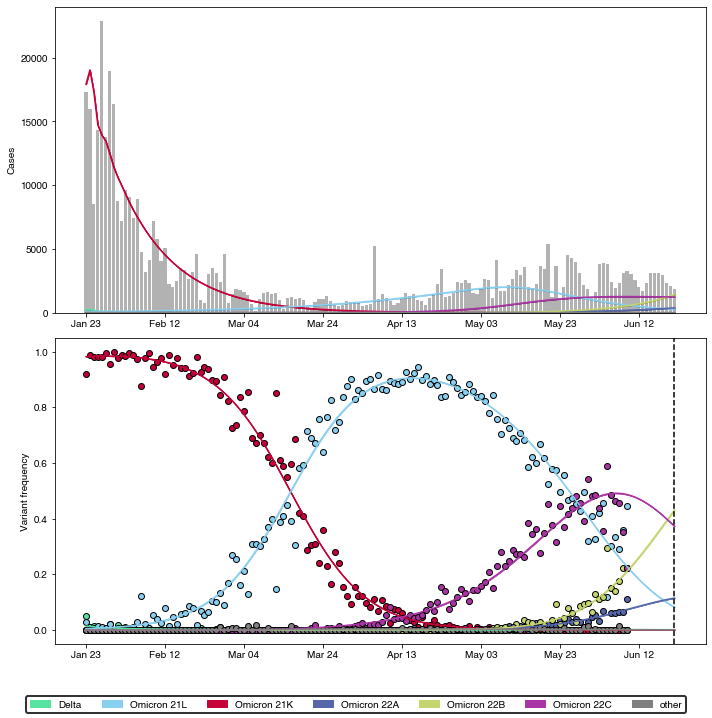

In [8]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(nrows=2, ncols=1)

colors = [color_map[v] for v in variant_data.var_names] # Mapping colors to observed variants

# Plot variant specific indicidence
ax = fig.add_subplot(gs[0,0])
plot_posterior_I(ax, posterior.samples, ps, alphas, colors)
plot_cases(ax, variant_data)
ax.set_ylabel("Cases") # Making ylabel


# Plot predicted frequencies
ax = fig.add_subplot(gs[1,0], sharex=ax)
plot_posterior_frequency(ax, posterior.samples, ps, alphas, colors)
plot_observed_frequency(ax, variant_data, colors) # Plot observed frequencies

ax.axvline(x=len(variant_data.dates)-1, color='k', linestyle='--') # Adding forecast cut off
add_dates_sep(ax, ef.data.expand_dates(variant_data.dates, forecast_L), sep=20) # Adding dates
ax.set_ylabel("Variant frequency") # Making ylabel


# Make legend
patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
legend.get_frame().set_linewidth(2.)
legend.get_frame().set_edgecolor("k")
fig.tight_layout()
fig.subplots_adjust(bottom = 0.1)

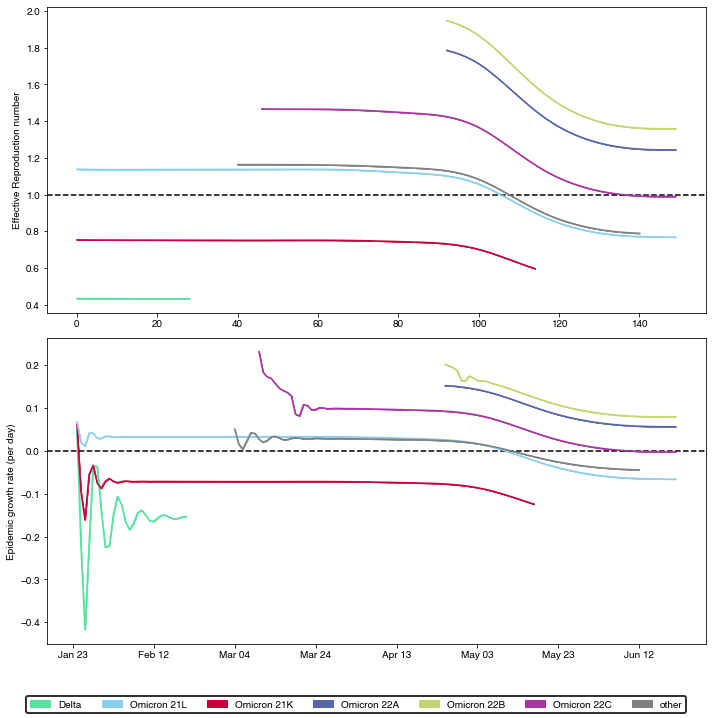

In [9]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(nrows=2, ncols=1)

colors = [color_map[v] for v in variant_data.var_names] # Mapping colors to observed variants

# Plot Reff
ax = fig.add_subplot(gs[0,0])
plot_R_censored(ax, posterior.samples, ps, alphas, colors)
ax.set_ylabel("Effective Reproduction number") # Making ylabel

# Plot little R
ax = fig.add_subplot(gs[1,0])
plot_little_r_censored(ax, posterior.samples, ps, alphas, colors)
add_dates_sep(ax, variant_data.dates, sep=20) # Adding dates
ax.set_ylabel("Epidemic growth rate (per day)") # Making ylabel


# Make legend
patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
legend.get_frame().set_linewidth(2.)
legend.get_frame().set_edgecolor("k")
fig.tight_layout()
fig.subplots_adjust(bottom = 0.1)